# Proof of principle: Predicting ATAC-seq in plants with Deep Learning
This notebook is the documentation of the proof of principle experiment for predicting ATAC-seq in plants with Deep Learning. The code shown here is to test the neural network (NN) architecture used to reach this goal and to evaluate the final runs on the high performance cluster (HPC) of the Heinrich Heine Universität Düsseldorf (HHU). The code shown is by no means finished; a final version of this network will at some point be found on the GitHub page: https://github.com/weberlab-hhu. All code exept the bash scripts for starting interactive jobs on the HPC is written in the programming language ``Python 3`` (van Rossum & Drake, 2009).

## Table of Contents
1. Introduction
>1.1 Setup  
>1.2 Data explanation  
2. Data preparation
>2.1 Dataset creation  
>2.2 Artificial dataset creation  
3. NN parameters
>3.1 Normal NN parameters  
>3.2 Artificial NN parameters  
4. The Neural Network
>4.1 Custom functions  
>4.2 The NN architecture  
>4.3 Pytorch Lightning functions   
>4.4 Model visualization  
5. Training
6. Testing
7. Evaluation of server training runs   
>7.1 The hybrid model   
>7.2 The CNN   
>7.3 Conclusion   
8. References

## 1. Introduction
### 1.1 Setup  
The packages shown below are necessary to import first.

In [1]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import pytorch_lightning as pl

### 1.2 Data explanation
The data used in this project is stored in h5 files. H5 files (also called HDF5, Hierarchical Data Format 5) are designed to store and organize large amounts of data. They constist of two major components:   
- Datasets (multidimensional arrays)
- Groups (container structures; can hold datasets and other groups)  
  
Below are the paths to the first two plant species datasets used for this proof of principle experiment first on ``troodon`` (the work station at the HHU) and on ``Stardust`` (home/private PC). The files are read into memory using the python package h5py (Collette, 2013).

In [9]:
# Paths on troodon:
# fpath = "/mnt/data/feli/prototyping_data/Athaliana/h5/test_data.h5"
# gpath = "/mnt/data/feli/prototyping_data/Bdistachyon/h5/bdistachyon_test_data.h5"

# Path on Stardust:
fpath = "data/athaliana_test_data.h5" # path on home pc
gpath = "data/bdistachyon_test_data.h5" 

f = h5py.File(fpath, mode="r") # read in the h5 file
g = h5py.File(gpath, mode="r")

H5 file architecture example:

The data is from the two plant species *Arabidopsis thaliana* (Tannenbaum et al., 2018) and *Brachypodium distachyon* (An et al., 2020; Lu et al., 2019).   
The important datasets are:   
- X:
    - the input/DNA sequence data
    - the nucleotides are vectors: ``[1 0 0 0]`` is C, ``[0 1 0 0]`` is A, ``[0 0 1 0]`` is T, ``[0 0 0 1]`` is G and ``[0.25 0.25 0.25 0.25]`` is N
    - ``[0 0 0 0]`` represents padding, meaning when the sequence data is cut into chunks, 21384 base pairs (bp), this adds "nucleotides" to get the same length no matter the length of the original sequence
- atacseq_coverage:
    - the ground truth/actual ATAC-seq read coverage data, the network will learn to predict
    - the read coverage is represented in reads per bp
    
**ATAC-seq** is short for Assay for Transposase-Accessible Chromatin using sequencing. For this assay, hyperactive mutant Tn5-Transposase carrying sequencing adapters is added to cells (for example _A. thaliana_ root cells). The cells contain DNA with closed chromatin and open chromatin regions (OCRs). Promotors and enhancers are, when a gene is under active transription, located at OCRs. Since the DNA is then accessible, transcription factors (TFs) can bind to the promoter (or another cis-regulatory element). The Transposase is cutting the DNA at OCRs and ligating the sequencing adapters to the resulting fragments. These DNA fragments are then amplified, sequenced and mapped to the reference genome resulting in read coverage per bp (Buenrostro et al., 2013).

## 2. Data preparation
The ``seqids`` array of the *A. thaliana* data has the order: Chr1, Chr2, Chr3, Chr4, Chr5, ChrM and ChrC. Since the chunks containing the mitochondrial and chloroplast genome are not useful for predicting promotors in the DNA, this data should be discarded.   
   
```python
seqids = list(f["data/seqids"])
fidx = seqids.index(b"ChrM") # first index of ChrM occurence in the list
print("Start of endosymbiont data:",fidx)
```
```
Start of endosymbiont data: 11150
```
   
In case of *B. distachyon* there are only scaffold names available, so the mitochondrial and chloroplast data cannot be identified and removed.   
   
```python
gseqids = list(g["data/seqids"])
print(set(gseqids))
```
```
{b'scaffold_12', b'Bd3', b'Bd1', b'Bd2', b'Bd4', b'scaffold_180', b'scaffold_14', b'scaffold_135', b'Bd1_centromere_containing_Bradi1g41430', b'Bd5'}
```
Later on the endosymbiont data will not be discarded anymore, as the model will be good enough to learn not to learn from this data.

### 2.1 Dataset creation
For the dataset creation functions two python packages are required: ``PyTorch`` (Paszke et al., 2019) and ``Pytorch Lightning`` (Falcon, 2019). The package ``Numpy`` (Harris et al., 2020) is optional.  
The input data is called ``X`` and the output data ``Y``. The *A. thaliana* data minus the mitochondrial and chloroplast information is used as the training set. The training set is what the NN gets to see and learn from by adjusting it's weights and biases. Part of the *B. distachyon* data will be used as the validation set and another part as the test set. The validation set is data the NN gets to see but not learn from, so it can be used as a measurement, how well the NN is generalizing or if it just learned to memorize the training set. The test set is data the neural network has never seen; this is also helpful to test it's accuracy.   
Since direct conversion from an h5 dataset (containing a ``numpy array``) to a ``pytorch tensor`` is not supported, the data first has to be converted to a ``numpy array``. Slicing the dataset already does this (for keeping the entire dataset replacing ``[:idx]`` with ``[:]`` is the way to go).   
For ``Y``, the last (third) dimension corresponds to the ATAC-seq coverage per bp. There are three/seven rows respectively instead of one because of the three/seven bam-files the data originates from. In order to get the total reads per bp, the rows need to be summed up.  
```python
print(f["atacseq_meta/bam_files"], g["atacseq_meta/bam_files"])
```
```
<HDF5 dataset "bam_files": shape (3,), type "|S512"> <HDF5 dataset "bam_files": shape (7,), type "|S512">
```
The datatype needs to be changed to ``float32`` as other datatypes don't work with the built-in pytorch functions and 32-bit floats are more computationally stable. 

**Function 1:**   
This first function was missing the masking of the data originating from the padded chromosome ends. A too short chunk is padded to achieve a length of 21384 bp. While the X data is padded with ``[0 0 0 0]``, the Y data is padded with ``-1``. This could lead to the network learning that negative ATAC-seq read coverage exists, which is not the case. Since most cis regulatory elements like promotors are not at the chromosome ends, this data will be excluded.   
```python
x = "data/X"
y = "evaluation/atacseq_coverage"

def h5_to_tensor(h5_dataset):
    data = torch.from_numpy(h5_dataset) # transform to tensor
    data = data.type(torch.float32) # change dtype to float32
    return data

def Y_transform(tensor):
    Y = tensor.sum(2)
    Y = F.normalize(Y) # normalize the data (to reduce bias)
    return Y

trainset = TensorDataset(h5_to_tensor(f[x][:11150]),Y_transform(h5_to_tensor(f[y][:11150])))
valset = TensorDataset(h5_to_tensor(g[x][:3000]),Y_transform(h5_to_tensor(g[y][:3000])))
testset = TensorDataset(h5_to_tensor(g[x][3000:3100]),Y_transform(h5_to_tensor(g[y][3000:3100])))
```

**Function 2:**       
The ``seed_everything()`` function from pytorch lightning sets a seed for pseudo-random number generators in: ``PyTorch``, ``Numpy`` and the standard package ``python.random``. The argument ``workers=True`` ensures reproducibility in the Dataloaders.

In [24]:
pl.utilities.seed.seed_everything(seed=233, workers=True)

Global seed set to 233


233

In [10]:
def h5_to_tensor(h5_data, idx1, idx2):
    data = h5_data[idx1:idx2]
    data = torch.from_numpy(data).to(torch.float32)
    return data


def create_dataset(h5_file, idx1, idx2):  # indices are temporary
    x_group = "data/X"
    y_group = "evaluation/atacseq_coverage"
    X = h5_to_tensor(h5_file[x_group], idx1, idx2)
    Y = h5_to_tensor(h5_file[y_group], idx1, idx2)
    Y = Y.sum(2)
    mask = [len(y[y < 0]) == 0 for y in Y]  # exclude padded ends
    X = X[mask]
    Y = Y[mask]
    return TensorDataset(X, Y)

In [11]:
trainset = create_dataset(f,None,11150) # 11150
valset = create_dataset(g,None,3000)
testset = create_dataset(g,3000,3100)

The size of three datasets ``trainset``, ``valset`` and ``testset`` is in this stage of the project undynamically defined. For runs on the HPC a larger amount of the available data will be used, especially from the *B. distachyon* dataset. Here only 3000 sequence chunks are used for validation and 100 for testing. This is because the entire dtaset would not fit into 16 Gb of RAM, which is what both the work station at the HHU and the private PC can use. Later on, the NN will get more plant speies to train on resulting in multiple files being the training/validation set.   
It is possible to save and load the datasets, so they don't have to be loaded into the jupyter environment everytime. The downside to this is that these datasets/tensors take up a few Gb of space. For comparison: the entire h5 file of *A. thaliana* is around 600 Mb in size, only the training set, which contains only part of this file is around 5 Gb in size.   
    
```python
torch.save(trainset,"datasets/trainset.pt")
trainset = torch.load("datasets/trainset.pt")
```

A graphical representation of a part of the DNA **input** sequence can be visualized:

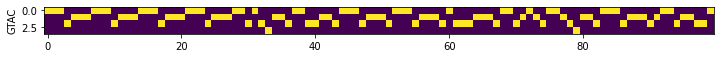

In [12]:
seq_part = trainset[0][0][0:100].T

plt.figure(figsize=(12, 8))
plt.imshow(seq_part) # for greyscale picture add: cmap="gray"
plt.ylabel("GTAC")
plt.show()

Convolutional layers can extract information out of the encoded DNA sequence. Here is an example of a convolutional layer that extracts 64 features from two bp (so it computes 64 numbers out of 8 original ones):

<div class="alert alert-block alert-info">
    <b>Note</b>: The custom function Xpadding is needed for the code below to run (see 4.1).
</div>

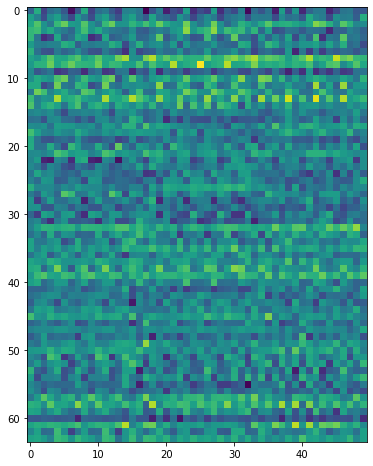

In [14]:
seq_part = seq_part.view(1,4,100)
xpad = Xpadding(100, 50, 2, 1, 9)
m = nn.Conv1d(4, 64, 9, stride=2,padding=xpad, dilation=1)
conv_seq = m(seq_part)

plt.figure(figsize=(12, 8))
plt.imshow(conv_seq.detach().view(64,50)) # for greyscale picture add: cmap="gray"
plt.show()

### 2.2 Artificial dataset creation:
<div class="alert alert-block alert-info">
    Note: Load the h5 file called <code>f</code> (<em>A. thaliana</em> data) and the <code>function 2</code> for creating datasets first.
</div>   
   
All artificial dataset creation functions are unelegant and only there to test a NN in its infant stage. The datasets are really small and constist of the actual DNA sequence as input and a fixed number for each of the four nuleotides (C, A, T, G; there are no Ns in these sequences) in the range 4 to 175, imitating count data.
#### 2.2.1 Training set

In [6]:
# artificial input X
mini_trainset = create_dataset(f,None,2)
mini_chunk = mini_trainset[0][0][0:300] # get the first 300 bp of the first chunk of the mini training set
artX = torch.chunk(mini_chunk,3,dim=0) # make three chunks of 100 bp size out of them
artX = torch.stack(artX) # stack the three chunks
print(artX.size())

torch.Size([3, 100, 4])


In [ ]:
# function to generate artificial Y
def artY_create(artificial_X):
    ylist = []
    
    C = torch.tensor([1., 0., 0., 0.])
    A = torch.tensor([0., 1., 0., 0.])
    T = torch.tensor([0., 0., 1., 0.])
    G = torch.tensor([0., 0., 0., 1.])
    
    for chunk in range(len(artX)):
        l=[]
        for i in artX[chunk]:
            if torch.equal(C,i):
                l.append(175)
            elif torch.equal(A,i):
                l.append(4)
            elif torch.equal(T,i):
                l.append(42)
            elif torch.equal(G,i):
                l.append(99)
        ylist.append(torch.FloatTensor(l))
    return torch.stack(ylist)

In [7]:
artY = artY_create(artX)
print(artY.size())

In [10]:
# artificial training set
art_trainset = TensorDataset(artX,artY)

#### 2.2.2 Validation set

In [11]:
artXval = mini_trainset[0][0][300:400]        
artYval = artY_create(artXval)

# change shape
artXval = artXval.view(1,100,4)
artYval = artYval.view(1,100)

# artificial validation set
art_valset = TensorDataset(artXval,artYval)

torch.Size([100, 4]) torch.Size([100])


## 3. NN parameters
The NN/model hyperparameters below will in the final script (``final_name.py``)be given to the program via the command line using the standard python package ``argparse``.   
Right now there are a few parameters, that can not be dynamically defined yet:   
- the output size of the model (needs to always be 1)
- the optimizer algorithm
- the loss function (should probably not be changable)
- the upscaling parameter of the convolutional layers
   
Known problems/improvements that will be applied to the python file of this network:   
- the sequence length has to be divisible by the step/steps for multiple convolutional layers
   
The hyperparameters are:   
   
|Parameter          |default|HPC runs|
|-------------------|-------|--------|
|Epochs             |10     |500     |
|Batch size         |25     |100     |
|Test batch size    |10     |/       |
|LSTM layers        |1      |1       |
|LSTM units         |16     |256     |
|CNN layers         |1      |3       |
|Linear layers      |1      |0       |
|Kernel size        |5      |9       |
|Filter size        |16     |64      |
|Step               |4      |2       |
|Learning rate      |1e-3   |1e-3    |
|Dilation           |1      |1       |
|Sequence length    |21384  |21384   |
|Nucleotides        |4      |4       |
|Seed               |/      |233     |
|**Parameter count**|3057   |897,985 |
   
In the future, the ``dilation`` option will be erased. A dilation of 1 means no dilation, while 2 would mean that for example a NN with kernel size 9 would look at 9 positions, but with a gap inbetween them, meaning it would have a wider field to look at but skip positions. For image regocnition this can be advantagous, but for a DNA sequence the exact order is important, so it is best not to skip anything.  
The ``pt_device`` will also be omitted, as the LSTM can initialize the hidden and cell state itself with zeros (here this is done with random numbers between 0 and 1).  
The option for more linear layers than the final output layer will also be removed. More linear layers have made no improvement in the NN predictions.   
   
### 3.1 Normal NN parameters

In [7]:
epochs = 3
batch_size = 35
test_batch_size = 20
cnn_layers = 3
lstm_layers = 1
lstm_units = 256
kernel_size = 9
filter_size = 64
linear_layers = 0 # not counting final output layer
step = 2
learning_rate = 0.001
dilation = 1
device = "gpu"
pt_device = "cuda"
num_devices = 1

# undynamic for seq_len and nucleotides here (dynamic option above as comment)
# seq_len = trainset[0][0].size(0)
seq_len = 21384
# nucleotides = trainset[0][0].size(1)
nucleotides = 4

To optimize performance the documentation recommends using the ``num_workers = number`` option, where number should be the number of CPU cores of the machine. Due to it being not clear if this setting has an influence on the results of the NN, and it not working on a Windows machine (private PC), itwill not be used.

In [32]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, pin_memory=True)

### 3.2 Artificial NN parameters

In [72]:
epochs = 100
batch_size = 1
# test_batch_size = 20
cnn_layers = 2
lstm_layers = 2
lstm_units = 16
kernel_size = 5
filter_size = 16
linear_layers = 0
step = 2
learning_rate = 0.001
dilation = 1
device = "gpu"
pt_device = "cuda"
num_devices = 1

seq_len=100
nucleotides=4

In [15]:
# artificial dataloaders
train_loader = DataLoader(art_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(art_valset, batch_size=batch_size, shuffle=False, pin_memory=True)

## 4. The Neural Network
### 4.1 Custom functions
**Xpadding:** To achieve the right output size of the tensor after being fed through the convolutional layer, padding can be necessary. Therefore this formula was rearanged from the ``PyTorch`` formula to calculate L_out. The input of the convolutional layer is defined as: $(N, C_{in}, L_{in})$ and the output as: $(N, C_{out}, L_{out})$. The padding formula is: $ padding = ⌈\frac{(L_{out}-1)*stride - L_{in} + dilation*(kernelsize - 1) + 1}{2}⌉ $.   
<div class="alert alert-block alert-info">
    <b>Note</b>: The brackets around the equation mean the resulting number needs to be rounded up.
</div>

In [8]:
def Xpadding(L_in,L_out,stride,dilation,kernel_size): 
    padding = math.ceil(((L_out-1)*stride - L_in + dilation*(kernel_size - 1) + 1)/2)
    # math.ceil to  avoid rounding half to even/bankers rounding, only needed for even L_in
    return padding

**Ypadding & y_pool:** Since the predicted values are pooled using the convolutional layer in the network, the target values need to be pooled too, so it is possible to compare them. The padding formula for the average pooling (take the average of a number of values defined by step) is: $ padding = ⌈\frac{(L_{out}-1)*stride - L_{in} + kernelsize}{2}⌉ $. The ``y_pool`` function applies the padding the same way it was done for the input X while being fed through the convolutional layers. 

In [9]:
def Ypadding(L_in,L_out,stride,kernel_size): 
    padding = math.ceil(((L_out-1)*stride - L_in + kernel_size)/2)
    # math.ceil to  avoid rounding half to even/bankers rounding, only needed for even L_in
    return padding

In [10]:
def y_pool(target):
    for layer in range(cnn_layers):
        l_in = seq_len/step**layer
        l_out = seq_len/step**(layer + 1)
        ypad = Ypadding(l_in, l_out, step, kernel_size)
        target = F.avg_pool1d(target, kernel_size, stride=step, padding=ypad)
    return target

**pear_coeff:** Training and validation _accuracy_ can be calculated using the pearson coefficient. Since the native implementation of this coefficient is used by concatenating the prediction and target data into one tensor, a custom function is needed to easily calculate the coefficient between prediction and target. The coefficient ranges from -1 to 1, with 1 meaning the tensors are identical and -1 meaning they are opposite (like [1, 2, 3] and [-1, -2, -3]).   
   
**loss:** The loss function used for this data is the ``poisson negative log likelihood``. It is calculated using these formulas:   
```python
# for log_input=False
pnll = torch.mean(prediction-target*torch.log(prediction + eps)) # eps = 1e-8

# for log_input=True
pnll = torch.mean(torch.exp(prediction)-target*prediction)
```

In [11]:
def pear_coeff(prediction, target, is_log=True):
    if is_log:
        prediction = torch.exp(prediction)
    p = prediction - torch.mean(prediction)
    t = target - torch.mean(target)
    coeff = torch.sum(p*t)/(torch.sqrt(torch.sum(p**2))*torch.sqrt(torch.sum(t**2))+1e-8)
    # 1e-8 avoiding division by 0
    return coeff

**print_coverage_comparison:** This is a makeshift function to compare the prediction of the NN and the target values in a graph without having to write the entire block of code every time.

In [12]:
def print_coverage_comparison(prediction, target, idx, title, is_log=True):
    pred_example = prediction[idx].cpu().detach()
    target_example = target[idx].cpu().detach()
    if is_log:
        pred_example = torch.exp(pred_example)
    
    pred_example =  pred_example.view(pred_example.size(0))
    target_example = target_example.view(target_example.size(0))
    
    # Plot:
    plt.plot(pred_example, label="prediction")
    plt.plot(target_example, label="actual_coverage")
    plt.xlabel('position')
    plt.ylabel('ATAC-seq coverage')

    plt.title(title)
    plt.legend()
    plt.show()

### 4.2 The NN architecture
The NN architecture constists of three major parts: the convolutional layers, the LSTM and the linear output layer. The architecture was also tested without the LSTM layer, which made worse predictions (see 7.). The filter size (neuron count) of the convolutional layers is upscaled every layer by two (will be customizeable). This will for a original filter size of 64 and three layers result in 64 neurons in the first convolutional layer, 128 in the second and 256 in the third. The LSTM takes the the last filter size of the convolutional layers as input, the output can be customized. The ``h0`` and ``c0`` configuration in the forward function could and will be done automatically with ``PyTorch``, just with zeros instead of random numbers between 0 and 1. The code would then look like this:  
```python
# LSTM part:
# --------------
x,_ = self.lstm(x)  # _ = hn, cn (hidden and cell state)
```

Additional to the output layer more linear layers can be configured. This will not be possible in the future as they don't improve model performance and just waste resources.  
The functions in the NN after forward are unique to the ``Pytorch Lightning`` package (see 4.3).

In [13]:
class LitHybridNet(pl.LightningModule):
    def __init__(self, seq_len, input_size, cnn_layers, filter_size, kernel_size, step,
                 dilation, hidden_size, lstm_layers, linear_layers, output_size, learning_rate):
        super(LitHybridNet,self).__init__()
        self.seq_len = seq_len
        self.input_size = input_size
        self.cnn_layers = cnn_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.step = step
        self.dilation = dilation
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.linear_layers = linear_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # dummy example for model summary function in trainer
        self.example_input_array = torch.zeros(6, seq_len, input_size)
        
        # saves the hyperparameters in checkpoints if checkpointing is enabled
        self.save_hyperparameters()
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = []
        self.val_accuracy = []
        
        # CNN part:
        # -------------
        self.cnn_layer_list = nn.ModuleList()
        
        for layer in range(cnn_layers):
            l_in = seq_len/step**layer
            l_out = seq_len/step**(layer + 1)
            xpad = Xpadding(l_in, l_out, step, dilation, kernel_size)
            
            self.cnn_layer_list.append(nn.Conv1d(input_size , filter_size, kernel_size, stride=step,
                                                 padding=xpad, dilation=dilation))
            input_size = filter_size
            filter_size = filter_size*2
        
    
        # LSTM part:
        # --------------
        self.lstm = nn.LSTM(input_size=math.ceil(filter_size/2), hidden_size=hidden_size,
                            num_layers=lstm_layers, batch_first=True)
        # input: last dimension of tensor, output:(batch, sequence_length, hidden_size)
        
        # Linear part:
        # --------------
        self.linear_layer_list = nn.ModuleList()
        
        for layer in range(linear_layers):
            self.linear_layer_list.append(nn.Linear(math.ceil(filter_size/2),hidden_size))
        self.linear_layer_list.append(nn.Linear(hidden_size,output_size))
        # self.out = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        # CNN part:
        # -------------
        x = x.transpose(1,2) # convolution over the basepairs, change position of 2. and 3. dimension
        
        for layer in self.cnn_layer_list:
            x = F.relu(layer(x))

        x = x.transpose(1,2)
        
        # LSTM part:
        # --------------
        h0 = torch.rand(self.lstm_layers, x.size(0), self.hidden_size).requires_grad_().to(pt_device)  #hidden state
        c0 = torch.rand(self.lstm_layers, x.size(0), self.hidden_size).requires_grad_().to(pt_device)  #cell/internal state
        # size: (num_layers,batch_size,hidden_size)
        
        x,_ = self.lstm(x,(h0, c0))  # _=(hn, cn)
        
        # Linear part:
        # --------------
        for layer in self.linear_layer_list[:-1]:
            x = F.relu(layer(x))
            
        x = self.linear_layer_list[-1](x) # !!!!
        x = x.view(x.size(0),x.size(1))
        #x = self.out(x)
        return x
    
    def training_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        if batch_idx == (len(train_loader)-1):
            print(f"Epoch: {self.current_epoch}")
            print_coverage_comparison(pred, Y, idx=0, title="Training example", is_log=True)
        return {"loss": loss, "acc": acc.detach()}
    
    def training_epoch_end(self, training_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in training_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in training_step_outputs]).mean()
        print(f"avg train loss: {avg_loss.item()}")
        print(f"avg train accuracy: {avg_acc.item()}")
        self.train_losses.append(avg_loss.item())
        self.train_accuracy.append(avg_acc.item())
        self.log("avg_train_loss", avg_loss, logger=False)
        # needs to be logged in order to be monitored by the checkpoint function of the pl.Trainer
        
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        if batch_idx == (len(val_loader)-1):
            print_coverage_comparison(pred, Y, idx=0, title="Validation example", is_log=True)
        return {"loss": loss, "acc": acc.detach()}
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in validation_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in validation_step_outputs]).mean()
        print(f"avg val loss: {avg_loss.item()}")
        print(f"avg val accuracy: {avg_acc.item()}")
        self.val_losses.append(avg_loss.item())
        self.val_accuracy.append(avg_acc.item())
    
    def test_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        metrics = {"loss": loss.item(), "acc": acc.item()}
        self.log_dict(metrics, logger=False)
        return metrics
    
    def predict_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        return {"prediction": pred, "Y": Y}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

The model needs to be initialized with the custom NN parameters (see 3.).

In [14]:
hybrid_model = LitHybridNet(seq_len=seq_len, input_size=nucleotides, cnn_layers=cnn_layers, filter_size=filter_size,
                            kernel_size=kernel_size, step=step, dilation=dilation, hidden_size=lstm_units,
                            lstm_layers=lstm_layers, linear_layers=linear_layers, output_size=1,
                            learning_rate=learning_rate)

In [15]:
print(hybrid_model)

LitHybridNet(
  (cnn_layer_list): ModuleList(
    (0): Conv1d(4, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (2): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)


### 4.3 Pytorch Lightning functions
A ``LightningModule`` organizes PyTorch code into 6 sections:
- Computations (init)
- Train Loop (training_step)
- Validation Loop (validation_step)
- Test Loop (test_step)
- Prediction Loop (predict_step)
- Optimizers and LR Schedulers (configure_optimizers)
   
There are no ``.cuda()`` or ``.to(device)`` calls required. Lightning does these on its own.
   
#### 4.2.1 Training Step
The code for the training step is:   
```python
def training_step(self, batch, batch_idx):
    X, Y = batch
    Y = y_pool(Y)
    pred = self(x)
    loss = F.poisson_nll_loss(pred, Y, log_input=True)
    return loss
```
Under the hood, this is happening during training:   
```python
# put model in train mode and enable gradient calculation
model.train()
torch.set_grad_enabled(True)

outs = []
for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)
    outs.append(loss.detach())

    # clear gradients
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update parameters
    optimizer.step()
```
It is possible to add a logging mechanism that keeps track of the loss:   
```python
def training_step(self, batch, batch_idx):
    ...
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

# under the hood:
epoch_metric = torch.mean(torch.stack([x for x in outs]))
```
If something needs to be done at the end of each epoch, the method `training_epoch_end` can be overwritten:   
```python
def training_epoch_end(self, training_step_outputs):
    all_preds = torch.stack(training_step_outputs)
    ...
```   
#### 4.2.2 Validation Step
The code for the validation step is:   
```python
def validation_step(self, batch, batch_idx):
    X, Y = batch
    Y = y_pool(Y)
    pred = self(x)
    loss = F.poisson_nll_loss(pred, Y, log_input=True)
    return loss
```
Under the hood, this is happening during validation:  
```python
# ...
for batch_idx, batch in enumerate(train_dataloader):
    loss = model.training_step(batch, batch_idx)
    loss.backward()
    # ...

    if validate_at_some_point:
        # disable grads + batchnorm + dropout
        torch.set_grad_enabled(False)
        model.eval()

        # ----------------- VAL LOOP ---------------
        for val_batch_idx, val_batch in enumerate(val_dataloader):
            val_out = model.validation_step(val_batch, val_batch_idx)
        # ----------------- VAL LOOP ---------------

        # enable grads + batchnorm + dropout
        torch.set_grad_enabled(True)
        model.train()
```
For running just the validation loop:
```python
model = Model()
trainer = Trainer()
trainer.validate(model)
```
   
#### 4.3 Test Step
The test loop is only called when `test.()` is used. There are two ways to call it: 
```python
# call after training
trainer = Trainer()
trainer.fit(model)

# automatically auto-loads the best weights from the previous run
trainer.test(dataloaders=test_dataloader)

# or call with pretrained model
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
trainer.test(model, dataloaders=test_dataloader)
```
<div class="alert alert-block alert-warning">
<b>Important:</b> It is recommended to validate on a single device to ensure each sample/batch gets evaluated exactly once. Otherwise, in a multi-device setting, samples could occur duplicated when DistributedSampler is used, as it replicates some samples on some devices to make sure all devices have same batch size in case of uneven inputs.</div>
    
#### 4.4 Prediction Step
The code for the predict step is:   
```python
def prediction_step(self, batch, batch_idx):
    X, Y = batch
    pred = self(X)
    return pred
```
Under the hood:   
```python
# disable grads + batchnorm + dropout
torch.set_grad_enabled(False)
model.eval()
all_preds = []

for batch_idx, batch in enumerate(predict_dataloader):
    pred = model.predict_step(batch, batch_idx)
    all_preds.append(pred)
```
<div class="alert alert-block alert-info">
    <b>Note</b>: The resulting prediction is a list of tensors.
</div>  
  
There are two ways to call `predict()`:
```python
# call after training
trainer = Trainer()
trainer.fit(model)

# automatically auto-loads the best weights from the previous run
predictions = trainer.predict(dataloaders=predict_dataloader)

# or call with pretrained model
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
predictions = trainer.predict(model, dataloaders=test_dataloader)
```

### 4.4 Model Visualization
For network visualization the model can be exported into the ``ONNX`` format.   
```python
import torch.onnx
dummy_input = torch.rand(1,21384,4).to(device)
torch.onnx.export(hybrid_model, dummy_input, "hybrid_model.onnx", input_names=["DNA Sequence"],
                  output_names=["ATACseq Read Coverage"])
```
This file can then be used with browser applications to create a ``png`` file of the network:   
- VisualDL, Link: https://www.paddlepaddle.org.cn/paddle/visualdl/demo/graph
- Netron, Link: https://github.com/lutzroeder/netron
    
It is also possible to check how many **parameters** the network has (the ``Pytorch Lightning`` summary function will also output a rounded number of parameters).   
```python
n = 0
for i in hybrid_model.state_dict().values():
    n += i.numel()    
print(n)
```

## 5. Training

Before starting to train the NN, it can be useful to check the GPU memory availability:   
```python
total = (torch.cuda.get_device_properties(0).total_memory/1000000)
res = (torch.cuda.memory_reserved(0)/1000000)
al = (torch.cuda.memory_allocated(0)/1000000)
free = (res-al)
print(f"GPU memory\n---------------------\ntotal: {total} Mb\nreserved: {res} Mb\nallocated: {al} Mb\nfree: {free} Mb")
```
```
GPU memory
---------------------
total: 4294.705152 Mb
reserved: 0.0 Mb
allocated: 0.0 Mb
free: 0.0 Mb
```
``Pytorch Lightning`` uses a callback function to configure certain actions of the model during training. The ``PrintCallback`` class can show when training started and finished. The ``ModelCheckpoint`` class can be used to define how the trained models are supposed to be saved. Here the top three models are saved to a specific directory (checkpoints) under the name: hybrid_model_``[epoch]_[avg_train_loss]``.ckpt (example: hybrid_model_epoch=401_avg_train_loss=-91.61.ckpt). The ``ModelSummary`` class allows for a model overview being printed before the training starts.

In [28]:
from pytorch_lightning.callbacks import ModelSummary, Callback, ModelCheckpoint

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")
        
checkpoint_callback = ModelCheckpoint(save_top_k=3, monitor="avg_train_loss", mode="min",
                                      dirpath="./checkpoints",
                                      filename="hybrid_model_{epoch}_{avg_train_loss:.2f}",
                                      save_on_train_epoch_end=True)
        
callbacks = [PrintCallback(), ModelSummary(max_depth=-1), checkpoint_callback]

Below is an example of a NN training for three epochs. The NN parameters/architecture is shown in the model summary.

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params | In sizes                                     | Out sizes                                   
-------------------------------------------------------------------------------------------------------------------------------------------------
0 | cnn_layer_list      | ModuleList | 76.2 K | ?                                            | ?                                           
1 | cnn_layer_list.0    | Conv1d     | 2.4 K  | [6, 4, 21384]                                | [6, 64, 10692]                              
2 | cnn_layer_list.1    | Conv1d     | 73.9 K | [6, 64, 10692]                               | [6, 128, 5

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 233


avg val loss: 0.4292781949043274
avg val accuracy: -0.0026946580037474632
Training started!


Training: 0it [00:00, ?it/s]

Epoch: 0


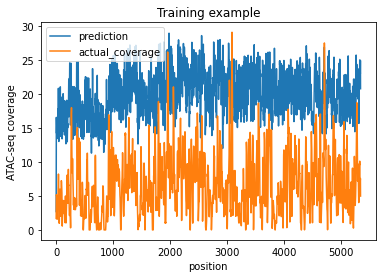

Validating: 0it [00:00, ?it/s]

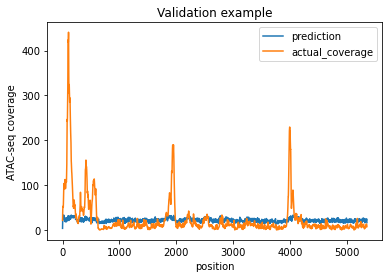

avg val loss: -91.00930786132812
avg val accuracy: 0.22697576880455017
avg train loss: -52.88807678222656
avg train accuracy: 0.07066493481397629
Epoch: 1


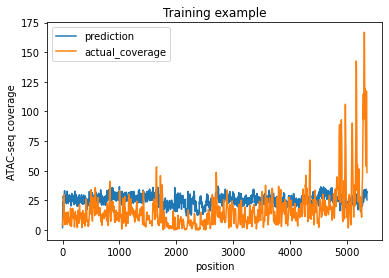

Validating: 0it [00:00, ?it/s]

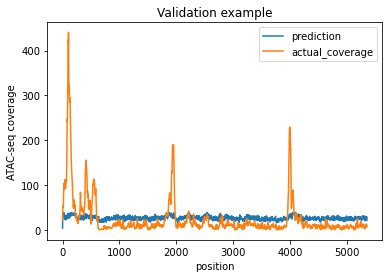

avg val loss: -93.18063354492188
avg val accuracy: 0.2300073206424713
avg train loss: -54.18815994262695
avg train accuracy: 0.10287322103977203
Epoch: 2


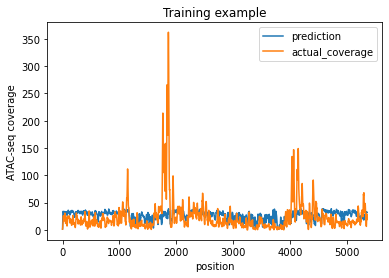

Validating: 0it [00:00, ?it/s]

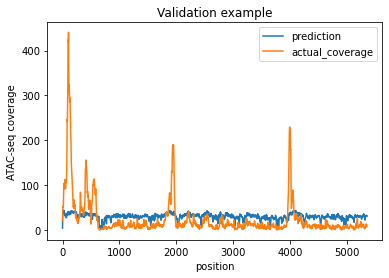

avg val loss: -94.23238372802734
avg val accuracy: 0.2296822965145111
avg train loss: -54.28614044189453
avg train accuracy: 0.13984602689743042
Training is done.


In [43]:
trainer = pl.Trainer(callbacks=callbacks, devices=num_devices, accelerator=device, max_epochs=epochs,
                     logger=False, enable_progress_bar=True, deterministic=True)
trainer.fit(model=hybrid_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# deterministic enables cudnn.deterministic, might slow training down, but ensures reproducibility

Example plot of the training and validation losses:

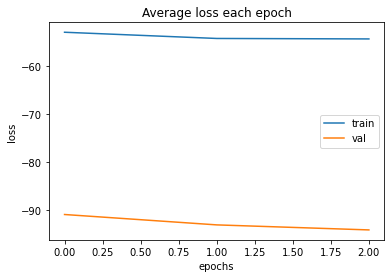

In [44]:
plt.plot(hybrid_model.train_losses, label="train")
plt.plot(hybrid_model.val_losses[1:], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.title("Average loss each epoch")
plt.legend()
plt.show()

Example plot of the training and validation accuracies:

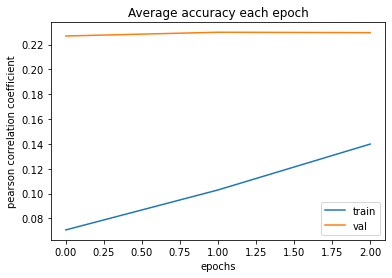

In [46]:
plt.plot(hybrid_model.train_accuracy, label="train")
plt.plot(hybrid_model.val_accuracy[1:], label="val")
plt.xlabel("epochs")
plt.ylabel("pearson correlation coefficient")

plt.title("Average accuracy each epoch")
plt.legend()
plt.show()

## 6. Testing

The best of the three best models trained (in this example there are only three) can then be used for testing and/or prediction. The function ``hybrid_model.load_from_checkpoint(checkpoint_callback.best_model_path)`` automatically selects the best model in the checkpoint path defined in the callback option of the ``trainer``. The used hyperparameters can also be examined.
<div class="alert alert-block alert-info">
    <b>Note</b>: To load from a checkpoint the model has to be preinitialized with the same parameters used for training it first.
</div>

In [47]:
best_model = torch.load("checkpoints/hybrid_model_epoch=2_avg_train_loss=-54.29.ckpt")
print(best_model['hyper_parameters'])

{'seq_len': 21384, 'input_size': 4, 'cnn_layers': 2, 'filter_size': 64, 'kernel_size': 9, 'step': 2, 'dilation': 1, 'hidden_size': 128, 'lstm_layers': 1, 'linear_layers': 0, 'output_size': 1, 'learning_rate': 0.001}


In [48]:
best_hybrid_model = hybrid_model.load_from_checkpoint("checkpoints/hybrid_model_epoch=2_avg_train_loss=-54.29.ckpt")

In [49]:
trainer.test(best_hybrid_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\fkind\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': 0.24245956540107727, 'loss': -106.94649505615234}
--------------------------------------------------------------------------------


[{'loss': -106.94649505615234, 'acc': 0.24245956540107727}]

In [51]:
predict_list = trainer.predict(best_hybrid_model, dataloaders=test_loader)
# big list of dictionaries with predictions and targets

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 319it [00:00, ?it/s]

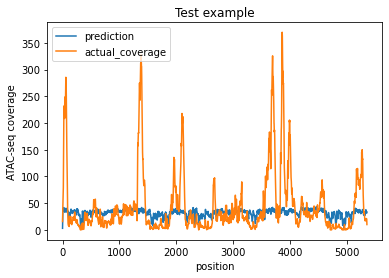

In [52]:
print_coverage_comparison(predict_list[0]["prediction"], predict_list[0]["Y"], idx=2, title="Test example", is_log=True)

The performance on the training set can also be evaluated with a slightly different code:

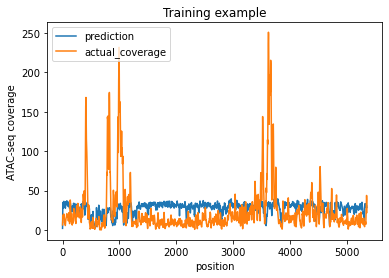

In [54]:
best_hybrid_model.to(pt_device)

with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in train_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break
        
print_coverage_comparison(pred, coverage, idx=0, title="Training example", is_log=True)

In [57]:
print("Accuracy:", pear_coeff(pred.cpu(),coverage, is_log=True).item())

Accuracy: 0.16466841101646423


## 7. Evaluation of server training runs
### 7.1 The hybrid model
The hybrid model contained in comparison to the CNN one LSTM layer, everything else was set up the same. The scripts used on the HPC are ``qsub_light_bigData.sh`` and ``predmotor_light_bigData.py``. The loss and the accuracy text files provided by the python script are used to evaluate the training.

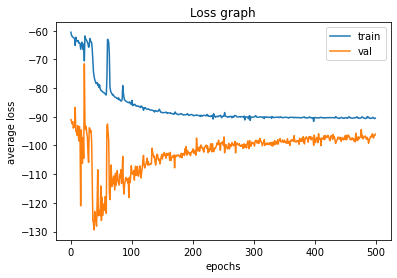

In [2]:
with open("loss_and_accuracy/data/hybrid_bigData_loss.txt", encoding="utf-8") as f:
    losses = f.readlines()
    
train_losses = [float(line.split()[1]) for line in losses[1:]]
val_losses = [float(line.split()[2]) for line in losses[1:]]

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel('epochs')
plt.ylabel('average loss')

plt.title("Loss graph")
plt.legend()
plt.show()

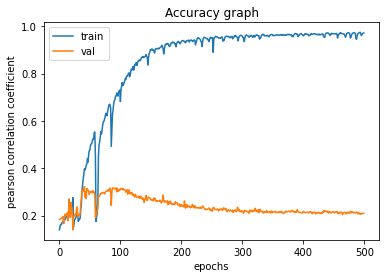

In [4]:
with open("loss_and_accuracy/data/hybrid_bigData_accuracy.txt", encoding="utf-8") as f:
    accuracies = f.readlines()
    
train_accuracy = [float(line.split()[1]) for line in accuracies[1:]]
val_accuracy = [float(line.split()[2]) for line in accuracies[1:]]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel('epochs')
plt.ylabel('pearson correlation coefficient')

plt.title("Accuracy graph")
plt.legend()
plt.show()

Then the model performance on the training and test set can be evaluated.
  
<div class="alert alert-block alert-info">
    <b>Note</b>: To load from a checkpoint the model has to be preinitialized with the same parameters used for training it.
</div>

In [12]:
best_hybrid_model = hybrid_model.load_from_checkpoint(
    "best_checkpoints/hybrid_model/hybrid_model_epoch=466_avg_train_loss=-91.05.ckpt")

Load a small subset of data that was used for training to check if the model under- or overfits. Load the part of the data the model has never seen, which will be the testset.

In [4]:
# Paths on troodon:
# fpath = "/mnt/data/feli/prototyping_data/Athaliana/h5/test_data.h5"
# gpath = "/mnt/data/feli/prototyping_data/Bdistachyon/h5/bdistachyon_test_data.h5"

# Path on Stardust:
fpath = "data/athaliana_test_data.h5" # path on home pc
gpath = "data/bdistachyon_test_data.h5" 

f = h5py.File(fpath, mode="r") # read in the h5 file
g = h5py.File(gpath, mode="r")

In [5]:
def h5_to_tensor(h5_data, idx1, idx2):
    data = h5_data[idx1:idx2]
    data = torch.from_numpy(data).to(torch.float32)
    return data


def create_dataset(h5_file, idx1, idx2):  # idx temporary
    x_group = "data/X"
    y_group = "evaluation/atacseq_coverage"
    X = h5_to_tensor(h5_file[x_group], idx1, idx2)
    Y = h5_to_tensor(h5_file[y_group], idx1, idx2)
    Y = Y.sum(2)
    mask = [len(y[y < 0]) == 0 for y in Y]  # exclude padded ends
    X = X[mask]
    Y = Y[mask]
    return TensorDataset(X, Y)

In [6]:
trainset = create_dataset(f,600,800)
testset = create_dataset(f, 11000,11160)

train_loader = DataLoader(trainset, batch_size=20,shuffle=False,pin_memory=True)
test_loader = DataLoader(testset, batch_size=20,shuffle=False,pin_memory=True)

**1.** Evaluate the performance on the **training set**

In [31]:
best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in train_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

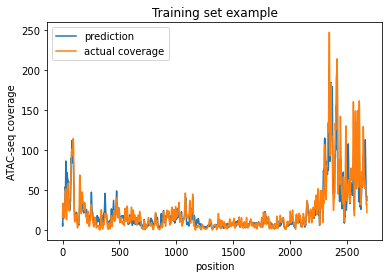

accuracy: 0.9197906255722046


In [37]:
print_coverage_comparison(pred, coverage, idx=4, title="Training set example", is_log=True)
print(f"accuracy: {pear_coeff(pred.cpu(),coverage, is_log=True)}")

**2.** Evaluate the performance on the **test set**  
   
The fastest method is to do the same loop for the ``test_dataloader`` as for the ``train_dataloader``, but it's also possible to configure a ``trainer`` again and test this way:  
```python
trainer = pl.Trainer(devices=num_devices, accelerator=device, max_epochs=epochs,
                     logger=False, enable_progress_bar=True, deterministic=False)

trainer.test(best_hybrid_model, dataloaders=test_loader)
predict_list = trainer.predict(best_hybrid_model, dataloaders=test_loader)
```
```
DATALOADER:0 TEST RESULTS
{'acc': 0.3555067479610443, 'loss': -227.42031860351562}
```
   
```python
# printing the comparison
print_coverage_comparison(predict_list[0]["prediction"], predict_list[0]["Y"], idx=2,
                          title="Test set example", is_log=True)
```

In [ ]:
# best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in test_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

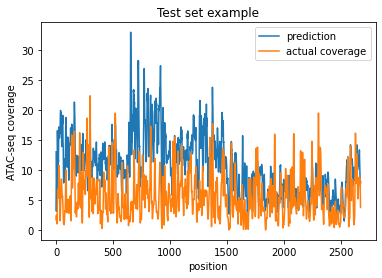

accuracy: 0.3555067479610443


In [40]:
print_coverage_comparison(pred, coverage, idx=2, title="Test set example", is_log=True)
print(f"accuracy: {pear_coeff(pred.cpu(),coverage, is_log=True)}")

### 7.2 The CNN
CNN stands for convolutional neural network. The scripts used on the HPC are ``qsub_light_bigData_cnn.sh`` and ``predmotor_light_bigData_cnn.py``. The loss and the accuracy text files provided by the python script are used to evaluate the training.

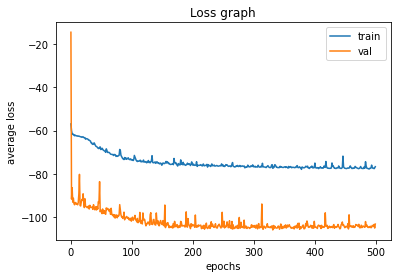

In [2]:
with open("loss_and_accuracy/data/cnn_bigData_loss.txt", encoding="utf-8") as f:
    losses = f.readlines()
    
train_losses = [float(line.split()[1]) for line in losses[1:]]
val_losses = [float(line.split()[2]) for line in losses[1:]]

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel('epochs')
plt.ylabel('average loss')

plt.title("Loss graph")
plt.legend()
plt.show()

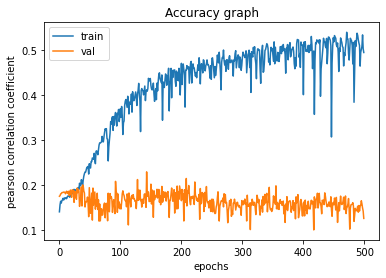

In [3]:
with open("loss_and_accuracy/data/cnn_bigData_accuracy.txt", encoding="utf-8") as f:
    accuracies = f.readlines()
    
train_accuracy = [float(line.split()[1]) for line in accuracies[1:]]
val_accuracy = [float(line.split()[2]) for line in accuracies[1:]]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel('epochs')
plt.ylabel('pearson correlation coefficient')

plt.title("Accuracy graph")
plt.legend()
plt.show()

Then the model performance on the training and test set can be evaluated.
  
<div class="alert alert-block alert-info">
    <b>Note</b>: To load from a checkpoint the model has to be preinitialized with the same parameters used for training it.
</div>
   
<div class="alert alert-block alert-warning">
<b>Important:</b> To preinitialize the CNN, the hidden_size and lstm_layers arguments need to be excluded from the model, as well as the LSTM part overall. (see 7.2.1)</div>  
  
The small subset of data loaded above in the hybrid model evaluation can be used again.  
  
**1.** Evaluate the performance on the **training set**

In [19]:
best_hybrid_model = hybrid_model.load_from_checkpoint(
    "best_checkpoints/cnn_model/cnn_model_epoch=378_avg_train_loss=-77.96.ckpt")

best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in train_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

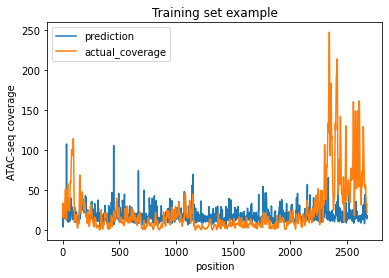

accuracy: 0.12518444657325745


In [20]:
print_coverage_comparison(pred, coverage, idx=4, title="Training set example", is_log=True)
print(f"accuracy: {pear_coeff(pred.cpu(),coverage, is_log=True)}")

**2.** Evaluate the performance on the **test set**  

In [21]:
# best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in test_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

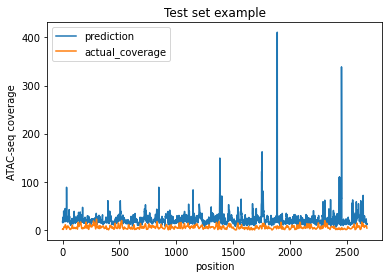

accuracy: 0.18348802626132965


In [22]:
print_coverage_comparison(pred, coverage, idx=2, title="Test set example", is_log=True)
print(f"accuracy: {pear_coeff(pred.cpu(),coverage, is_log=True)}")

#### 7.2.1 CNN model code

In [18]:
class LitHybridNet(pl.LightningModule):
    def __init__(self, seq_len, input_size, cnn_layers, filter_size, kernel_size, step,
                 dilation, linear_layers, output_size, learning_rate):
        super(LitHybridNet,self).__init__()
        self.seq_len = seq_len
        self.input_size = input_size
        self.cnn_layers = cnn_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.step = step
        #self.padding = padding
        self.dilation = dilation
        self.linear_layers = linear_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # for model summary in trainer
        self.example_input_array = torch.zeros(6, seq_len, input_size)
        
        # for checkpoints
        self.save_hyperparameters() #?
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = []
        self.val_accuracy = []
        
        # CNN part:
        # -------------
        self.cnn_layer_list = nn.ModuleList()
        
        for layer in range(cnn_layers):
            l_in = seq_len/step**layer
            l_out = seq_len/step**(layer + 1)
            xpad = Xpadding(l_in, l_out, step, dilation, kernel_size)
            
            self.cnn_layer_list.append(nn.Conv1d(input_size , filter_size, kernel_size, stride=step,
                                                 padding=xpad, dilation=dilation))
            input_size = filter_size
            filter_size = filter_size*2
        
    
        
        # Linear part:
        # --------------
        self.linear_layer_list = nn.ModuleList()
        
        for layer in range(linear_layers):
            self.linear_layer_list.append(nn.Linear(hidden_size,hidden_size))
        self.linear_layer_list.append(nn.Linear(math.ceil(filter_size/2),output_size))
    
    def forward(self,x):
        # CNN part:
        # -------------
        x = x.transpose(1,2) # convolution over the basepairs, change position of 2. and 3. dimension
        
        for layer in self.cnn_layer_list:
            x = F.relu(layer(x))

        x = x.transpose(1,2)
        
        # Linear part:
        # --------------
        for layer in self.linear_layer_list[:-1]:
            x = F.relu(layer(x))
            
        x = self.linear_layer_list[-1](x)
        x = x.view(x.size(0),x.size(1))
        return x
    
    def training_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        return {"loss": loss, "acc": acc.detach()}
    
    def training_epoch_end(self, training_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in training_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in training_step_outputs]).mean()
        self.train_losses.append(avg_loss.item())
        self.train_accuracy.append(avg_acc.item())
        self.log("avg_train_loss", avg_loss, logger=False)
        
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        return {"loss": loss, "acc": acc.detach()}
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in validation_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in validation_step_outputs]).mean()
        self.val_losses.append(avg_loss.item())
        self.val_accuracy.append(avg_acc.item())
    
    def test_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(pred, Y, is_log=True)
        metrics = {"loss": loss.item(), "acc": acc.item()}
        self.log_dict(metrics, logger=False)
        return metrics
    
    def predict_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        return {"prediction": pred, "Y": Y}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    
# 3.3 Initialize the model
#-------------------------------
hybrid_model = LitHybridNet(seq_len=seq_len, input_size=nucleotides, cnn_layers=cnn_layers, filter_size=filter_size,
                            kernel_size=kernel_size, step=step, dilation=dilation, linear_layers=linear_layers,
                            output_size=1, learning_rate=learning_rate)

### 7.3 Conclusion
The hybrid model outperforms the CNN in its prediction accuracy for both training and validation sets as well as the training and test examples. The LSTM layer therefore is a vital part in the NN architecture. Both models overfit, meaning they perform better on the training than the validation set, because they memorized the training examples and are not able to generalize well. This was expected as two species is not enough to properly train on. Still this proof of principle shows that ATAC-seq data can be learned by an NN using the hybrid model architecture and parameters.

## 8. References
- An, yunyun, Shen, W., Li, J., Zhong, S., & Li, P. (2020). Dynamic epigenome changes in response to light in Brachypodium distachyon. Authorea Preprints. https://doi.org/10.22541/AU.160336987.75933449/V1
- Buenrostro, J. D., Giresi, P. G., Zaba, L. C., Chang, H. Y., & Greenleaf, W. J. (2013). Transposition of native chromatin for fast and sensitive epigenomic profiling of open chromatin, DNA-binding proteins and nucleosome position. Nature Methods 2013 10:12, 10(12), 1213–1218. https://doi.org/10.1038/nmeth.2688
- Collette, Andrew. (2013). Python and HDF5.
- Falcon, W. (2019). Pytorch Lightning · GitHub. https://github.com/PyTorchLightning
- Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M. H., Brett, M., Haldane, A., del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/S41586-020-2649-2
- Lu, Z., Marand, A. P., Ricci, W. A., Ethridge, C. L., Zhang, X., & Schmitz, R. J. (2019). The prevalence, evolution and chromatin signatures of plant regulatory elements. Nature Plants 2019 5:12, 5(12), 1250–1259. https://doi.org/10.1038/s41477-019-0548-z
- Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Köpf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Fang, L., Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. Advances in Neural Information Processing Systems, 32. https://doi.org/10.48550/arxiv.1912.01703
- Tannenbaum, M., Sarusi-Portuguez, A., Krispil, R., Schwartz, M., Loza, O., Benichou, J. I. C., Mosquna, A., & Hakim, O. (2018). Regulatory chromatin landscape in Arabidopsis thaliana roots uncovered by coupling INTACT and ATAC-seq. Plant Methods, 14(1), 1–12. https://doi.org/10.1186/S13007-018-0381-9
- van Rossum, G., & Drake, F. L. (2009). Python 3 Reference Manual; CreateSpace. Scotts Valley, CA, 242. https://www.python.org/